In [1]:
from brian2 import *
from DynapSE import DynapSE

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import signal

In [3]:
#Firstly we define the head direciton signal.

#Following the paper of Sadeghi et al., we construct a broadband noise stimuli characterized by a Gaussian 
#distribution of rotational velocities with mean = 0 and std = 20 degrees/s. The Signal is then low-pass filtered at 
#30 Hz.

def gaussian_head_signal(mu, sigma, duration, freq):
    """
    Generates a time series signal of a broadband noise signal characterized by a Gaussian distribution with a 
    certain mean and standard deviation, corresponding to angular velocity. Plots the signal in time
    
    Args: 
        mu (float): mean of the gaussian distribution
        sigma (float): standard deviaiton of gaussian distribution
        duration (np.ndarray): number of time points to sample (s)
        freq (float): frequency boundary for low-pass filter
        
    Returns:
            head_signal (np.ndarray): signal of head direction velocities generated by the gaussian
            head_signal_filtered (np.ndarray): lowpass filtered head velocity signal
            freq_signal_filtered (np.ndarray): lowpass filtered frequency signal
        
    """
    
    
    
    x = np.linspace(0, duration, int(duration*1e3)) 
    head_signal = np.random.normal(mu, sigma*(np.pi/180), int(duration*1e3))#np.random.normal(mu, sigma*(np.pi/180), int(duration*1e3))
    
    
    sos = signal.butter(10, 30, 'lowpass', fs=1000, output='sos')
    freq_signal_filtered = signal.sosfilt(sos, head_signal/(2*np.pi))
    
    
    head_signal_filtered = freq_signal_filtered*(2*np.pi)*(180/np.pi)
    
    plt.figure(figsize=(8, 13))
    
    plt.subplot(211)
    plt.plot(x, head_signal, color='tab:blue')
    plt.title("Unfiltered head velocity stimulus")
    plt.xlabel("time (s)")
    plt.ylabel("rad/s")

    plt.subplot(212)
    plt.plot(x, head_signal_filtered, color='tab:orange')
    plt.title("Filtered head velocity stimulus")
    plt.xlabel("time (s)")
    plt.ylabel("degrees/s")
    
    #plt.subplot(224)
    #plt.plot(x, freq_signal_filtered, color='tab:red')
    
    plt.show()
    
    return head_signal, head_signal_filtered, freq_signal_filtered

In the neural variability paper, their head direction signal has mean 0 deg/sec and standard deviation of 20 deg/sec, therefore that is what we will be inputing into the neurons.

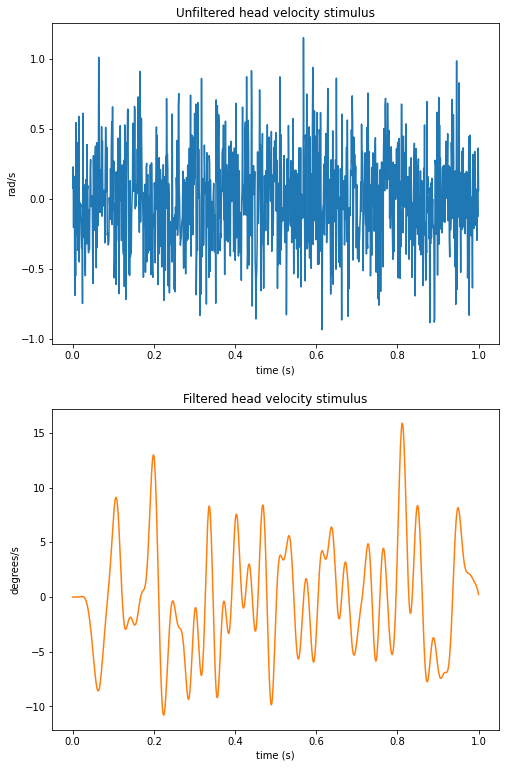

In [5]:
np.random.seed(77)

# Now test on mu = 0 and std = 20 deg as stated in the paper
mu = 0
sigma = 20
duration = 1
freq = 30

head_signal, head_signal_filtered, freq_signal  = gaussian_head_signal(mu, sigma, duration, freq)

To convert the signal into spikes, we used pulse frequency modulation.

In [84]:
def pulse_freq_modulation(signal, carrier_freq):
    
    """
    Given an input signal and a carrier frequency, the pulse frequency modulator returns a set of spikes that encode
    the amplitude of the signal.
    
    Args:
        signal (np.ndarray): analogue signal to encode
        carrier_freq (float): carrier frequency used to multiply the original signal and encode the spikes. Units = Hz
        
    Return:
            spikes (np.ndarray): time series with 1's when there is a spike and 0 otherwise
    """

    modulation_index = 1/np.amax(head_signal_filtered)


    time = np.arange(head_signal_filtered.shape[0]) / head_signal_filtered.shape[0]
    modulator = head_signal_filtered*(modulation_index)
    carrier = np.sin(2.0 * np.pi * carrier_freq * time)
    product = np.zeros_like(modulator)

    for i, t in enumerate(time):
        product[i] = np.sin(2. * np.pi * (carrier_freq * t + modulator[i]))


    spikes = numpy.where(numpy.diff(numpy.sign(product)))[0]    

    #Plot the different signal plots
    
    plt.figure(figsize = (10,20))
    plt.subplot(4, 1, 1)
    plt.plot(modulator)
    plt.ylabel('Amplitude')
    plt.xlabel('Modulator signal')
    
    plt.subplot(4, 1, 2)
    plt.plot(carrier)
    plt.ylabel('Amplitude')
    plt.xlabel('Carrier signal')

    plt.subplot(4, 1, 3)
    plt.plot(product)
    plt.ylabel('Amplitude')
    plt.xlabel('Output signal')


    plt.subplot(4, 1, 4)
    plt.plot(spikes, np.ones((spikes.shape)), ".")
    plt.ylabel('Spikes')
    plt.xlabel('Output signal')
    plt.show()
    
    return spikes

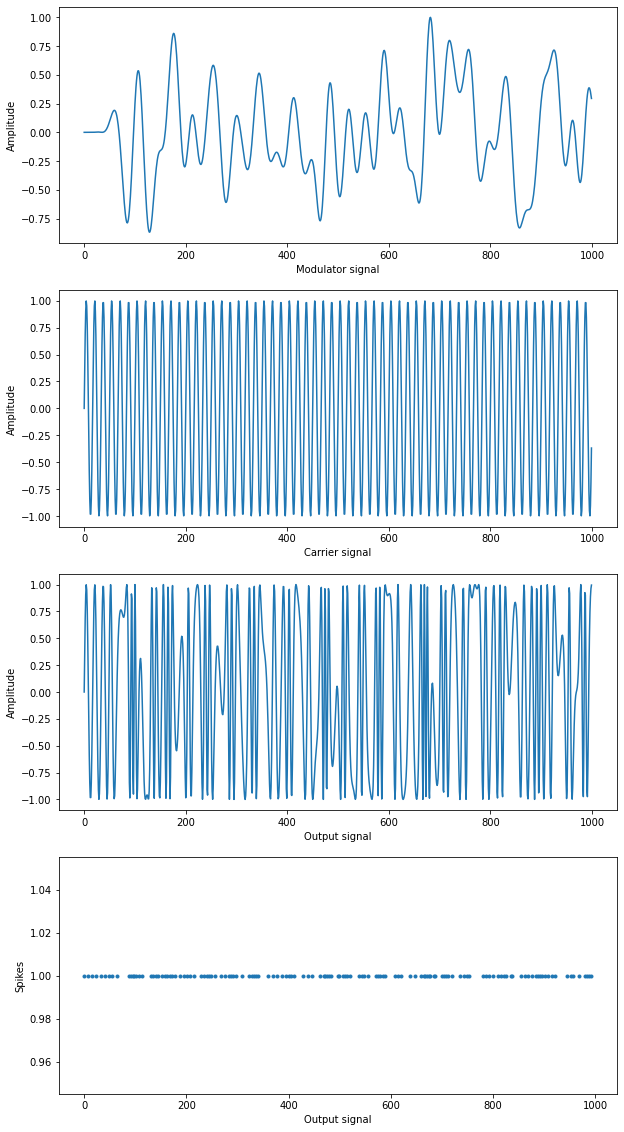

In [85]:
#Now we generate the spikes from our gaussian head direction signal

spikes = pulse_freq_modulation(head_signal_filtered, 60.0)

In [ ]:
#Now we send this signal to neuron 14 (regular) of chip=core=0 and this is the output we get spiking in the following times (ms)

#spike_response = np.array([ 15,  31,  49,  65,  83, 100, 116, 131, 150, 166, 184, 201, 218,
       234, 253, 268, 287, 303, 321, 339, 354, 370, 388, 404, 421, 437,
      453, 468, 484, 500, 516, 533, 549, 567, 582, 601, 618, 636, 651,
       669, 684, 702, 716, 735, 751, 769, 784, 801, 819, 835, 853, 869,
       885, 903, 919, 934, 950, 966, 982, 998])
        
#spike_response = np.array([  1.948,  32.795,  56.691,  84.479, 108.087, 144.201, 175.65 ,
       #205.976, 230.712, 262.247, 292.597, 331.354, 362.247, 395.315,
       #427.221, 463.181, 487.372, 523.33 , 549.698, 583.539, 602.46 ,
       #634.054, 671.196, 694.707, 731.672, 753.911, 778.512, 823.387,
       #850.274, 877.944, 907.198, 951.059])

In [114]:
unprocessed_vals = np.array([764,   8858,  16826,  26855,  38823,  45848,  56825,  70832,
        82836,  92858, 103832, 123825, 132772, 141846, 167813, 177805,
       185881, 199829, 216846, 224850, 233845, 258828, 269816, 280837,
       292813, 303836, 311841, 318849, 327848, 334855, 344806, 378772,
       386767, 396826, 406850, 417817, 428845, 437854, 444840, 453833,
       462837, 472852, 482874, 490854, 523812, 533798, 541870, 554831,
       565892, 589750, 596600, 602852, 630801, 640841, 654848, 661781,
       668599, 675850, 699818, 712590, 725839, 735806, 744890, 766817,
       773883, 780855, 793836, 806846, 816869, 826858, 834857, 843846,
       854841, 861780, 870838, 897848, 907873, 929845, 939850, 962834,
       970780, 978858, 985786]) 
min_sample = np.amin(unprocessed_vals)
print(min_sample)

spike_response = (unprocessed_vals - min_sample)/1e3
print(spike_response)

np.shape(spike_response)

764
[  0.      8.094  16.062  26.091  38.059  45.084  56.061  70.068  82.072
  92.094 103.068 123.061 132.008 141.082 167.049 177.041 185.117 199.065
 216.082 224.086 233.081 258.064 269.052 280.073 292.049 303.072 311.077
 318.085 327.084 334.091 344.042 378.008 386.003 396.062 406.086 417.053
 428.081 437.09  444.076 453.069 462.073 472.088 482.11  490.09  523.048
 533.034 541.106 554.067 565.128 588.986 595.836 602.088 630.037 640.077
 654.084 661.017 667.835 675.086 699.054 711.826 725.075 735.042 744.126
 766.053 773.119 780.091 793.072 806.082 816.105 826.094 834.093 843.082
 854.077 861.016 870.074 897.084 907.109 929.081 939.086 962.07  970.016
 978.094 985.022]


(83,)

In [115]:
#Inverting the signal of pulse frequency modulation

def binary_signal(signal, recording_duration):
    """
    Given a spike train with the spike times, create a binary signal of spikes
    
    Args:
        signal (np.ndarray): array of spike times
        recording_duration (float): duration of time the recording has lasted in ms
        
    Returns: 
            bsignal (np.ndarray): time series of binary signal
    """
    bsignal = np.zeros((recording_duration,))
    bsignal[signal] = 1
    
    return bsignal

Text(0.5, 1.0, 'Input spikes')

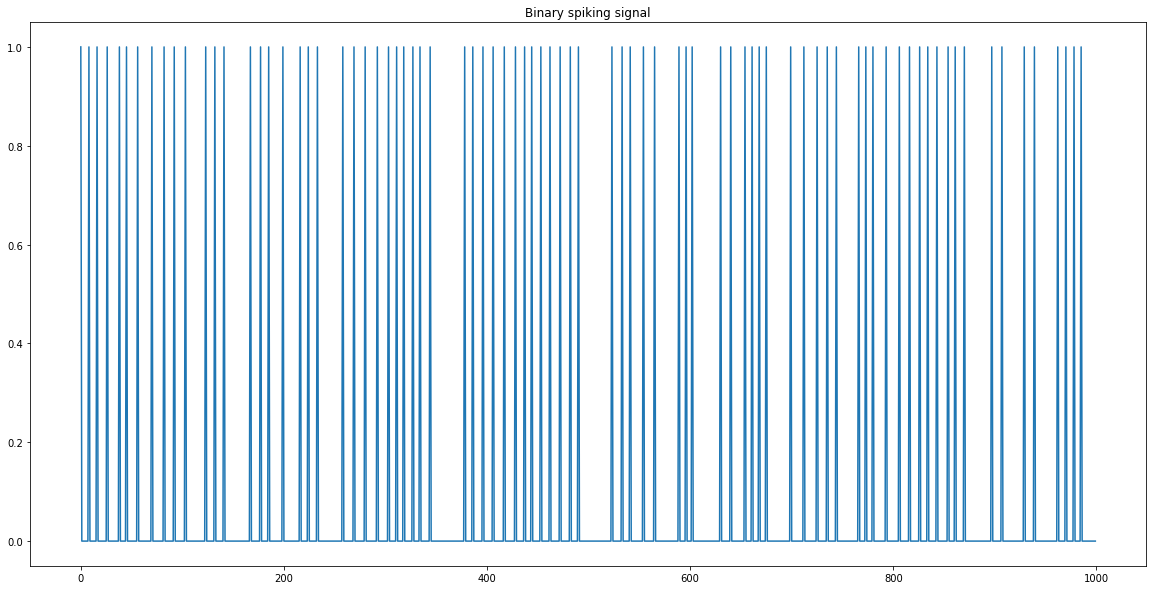

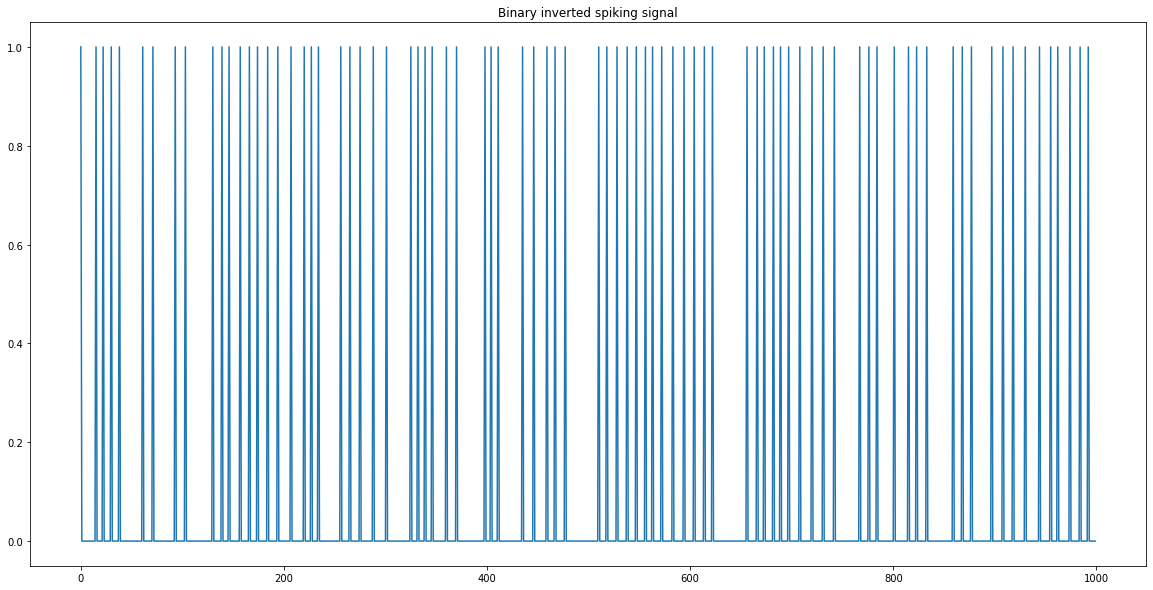

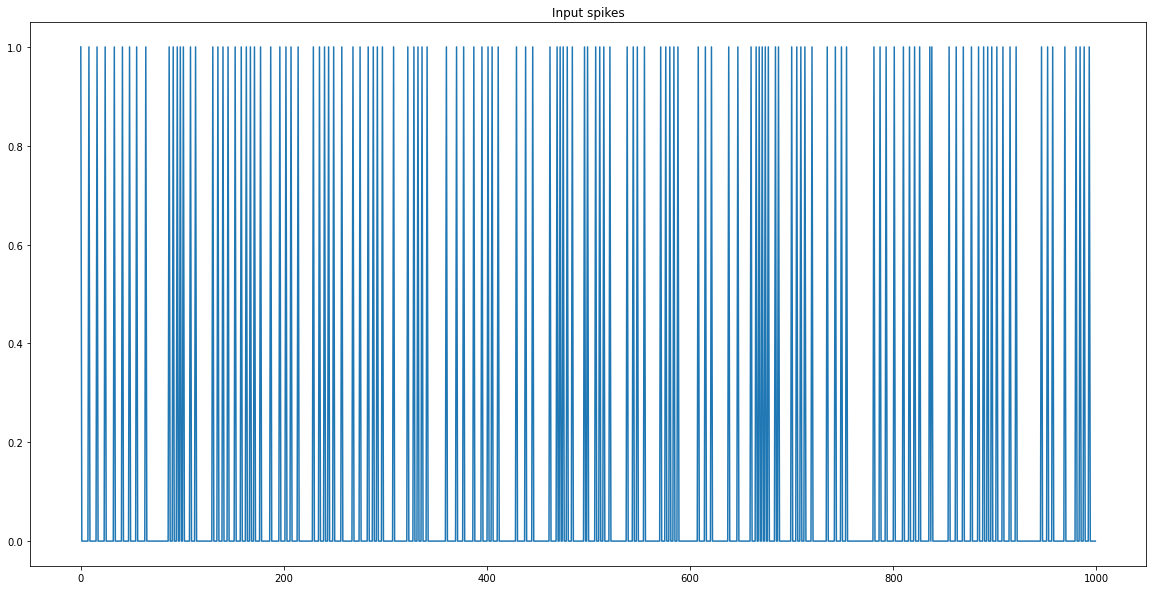

In [117]:
#we recorded the signal for 1000 micro s
recording_duration = 1000

#Now we wish to plot the spiking response inverted and non-inverted.

response = binary_signal(np.round(spike_response).astype(int),recording_duration)
response_flipped = binary_signal(np.round(-spike_response).astype(int),recording_duration)

plt.figure(figsize = (20,10))
plt.plot(response)
plt.title("Binary spiking signal")

plt.figure(figsize = (20,10))
plt.plot(response_flipped)
plt.title("Binary inverted spiking signal")

stimuli = binary_signal((spikes).astype(int), recording_duration)
plt.figure(figsize = (20,10))
plt.plot(stimuli)
plt.title("Input spikes")



Finally we reconstruct the signal from the spieks we get, as in the neural variability paper

(1000,)
[ 0.00000000e+00 -5.70517401e-10 -6.34964962e-09 ... -2.01155511e-01
 -6.78589593e-02  0.00000000e+00]


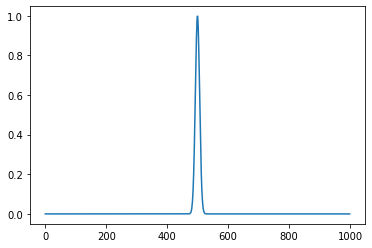

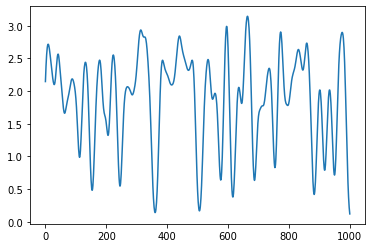

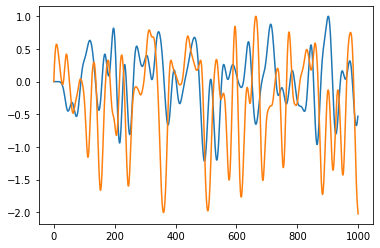

In [139]:
import scipy 
gauss = scipy.signal.gaussian(1000, 7, sym=True)
plt.plot(gauss)
print(gauss.shape)
recon = np.convolve(gauss,response)
plt.figure()
max_recon = np.amax(recon[500:1501]- recon[500])
plt.plot(recon[500:1501]/max_recon)

#plt.figure()
#plt.plot(response)

plt.figure()
max_head = np.amax(head_signal_filtered - head_signal_filtered[0])
plt.plot(head_signal_filtered/max_head)
plt.plot((recon[500:1501]- recon[500])/max_recon)

signal_correlation = scipy.signal.correlate((head_signal_filtered - head_signal_filtered[0])/max_head, (recon[500:1501]- recon[500])/max_recon)
print(signal_correlation)

In [140]:
def coherence(stimulus, output):
    """
    Calculates the coherence of the stimulus and the output of the neurons
    
    Args:
        stimulus (np.ndarray): time series stimulus
        output (np.ndarray): time series output of neuron
        
    Return:
            coherence (np.ndarray): value of coherence of output and stimulus signal for different frequency values
    """
    #Calculate the stimulus-response cross spectrum
    frs, Prs = signal.csd(stimulus, output)
    
    #Power spectrum of the spike train (output)
    #frr, Prr = signal.welch(output)
    
    frr, Prr = signal.csd(output, output)
    
    #Power spectrum of the stimulus
    #fss, Pss = signal.welch(stimulus)
    
    fss, Pss = signal.csd(stimulus, stimulus)
    
    Cf = (np.abs(Prs)**2)/(Prr*Pss) #coherence values
    
    
    
    return Cf, frs, frr, fss, Prs, Pss, Prr

In [141]:
stimulus = (head_signal_filtered - head_signal_filtered[0])/max_head
output = (recon[500:1501]- recon[500])/max_recon
Cf, frs, frr, fss, Prs, Pss, Prr= coherence(stimulus, output)
print(np.mean(Cf))

0.13387300476774805


In [12]:
def reconstruct_signal(response, response_flipped, stimuli):
    """
    Reconstructs the signal as shown in the neural variability paper, by convolving the spike train resposne with the
    kernel that minimizes the MSE.
    
    Args:
        response(np.ndarray): binary array contining the spikes
        response_flipped (np.ndarray): the flipped spike times (multiplied by -1)
    
    Returns:
            signal_estimate(np.ndarray): vaues of the reconstructed signal esitmate
    """

    #Computes the stimulus-response cross spectrum (the functio takes the fourier transform of the signal)
    f_rs, Prs = signal.csd(response_flipped,stimuli,scaling = "spectrum", nperseg = 1000)
    plt.semilogy(f_rs, Prs)
    plt.plot()
    plt.title("Stimulus-response cross spectrum")

    
    #Computes the power spectrum of the response: note that when using the welch function, very different results are
    #observed. Uncomment it and comment out the periodgram to see.
    
    f_rr, Prr = signal.welch(response, nperseg=1000)  
    #f_rr, Prr = signal.periodogram(response,scaling = "spectrum")
    plt.figure()
    plt.semilogy(f_rr, Prr)
    plt.title("Output response power-spectrum")

    #Kernel in the fourier domain that minimizes the MSE
    K_fourier = Prs / Prr
    
    K_fourier_real = K_fourier.real
    
    plt.figure()
    plt.plot(K_fourier)
    plt.title("Fourier transform of the kernel")
    
    #Inverting the fourier transform to get the kernel for the convolution
    kernel = np.fft.ifft(K_fourier_real)
    kernel_real = np.real(kernel)
    
    plt.figure()
    plt.plot(kernel)
    plt.plot(kernel_real)
    plt.title("Reconstruction kernel")

    #signal estimate by convolving the spike responses with the kernal
    signal_estimate = np.convolve(response, kernel_real)

    plt.figure()
    plt.plot(signal_estimate)
    plt.title("Signal reconstruction")
    
    return signal_estimate, K_fourier_real, kernel, kernel_real


WARNING    /Users/naimaelosegui/opt/anaconda3/envs/dynapse_sim/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
 [py.warnings]
WARNING    /Users/naimaelosegui/opt/anaconda3/envs/dynapse_sim/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
 [py.warnings]
WARNING    /Users/naimaelosegui/opt/anaconda3/envs/dynapse_sim/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
 [py.warnings]


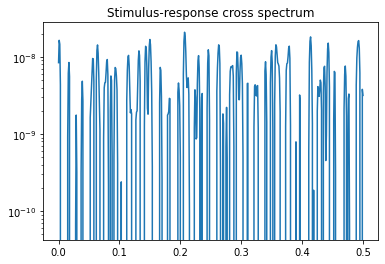

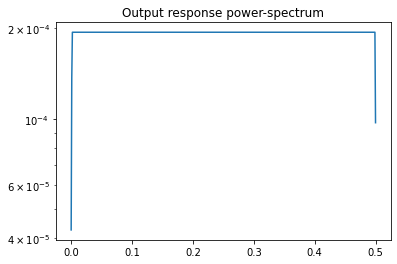

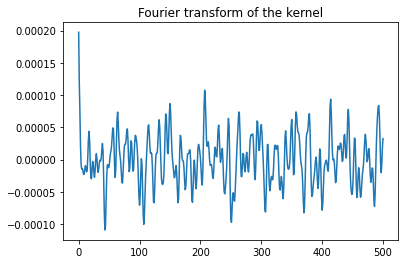

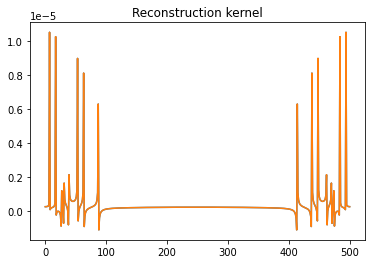

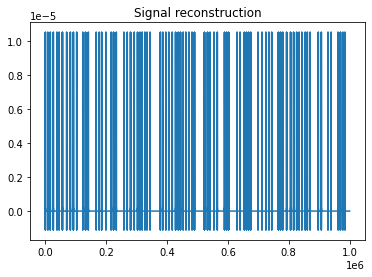

In [15]:
#Look at the reconstructed signal

signal_reconstructed, K_fourier, kernel, kernel_real = reconstruct_signal(response, response_flipped)

In [17]:
print("kernel_values", kernel_real)
print("Fourier transform of the kernel", K_fourier)

kernel_values [ 2.57608933e-07  2.58501962e-07  2.61411285e-07  2.67196848e-07
  2.78140658e-07  3.01274619e-07  3.71545715e-07  1.05062978e-05
  8.48373616e-08  1.59878610e-07  1.86799609e-07  2.03235589e-07
  2.17629073e-07  2.34702444e-07  2.60917409e-07  3.13093891e-07
  4.71464663e-07  1.02470244e-05 -2.32941454e-07 -6.33553791e-08
 -1.93824014e-08 -1.02218230e-08 -2.07711537e-08 -5.09939897e-08
 -1.12932650e-07 -2.55695666e-07 -8.83263955e-07  1.19210627e-06
  3.20831119e-07  2.40206206e-08 -7.16544198e-07  1.64462519e-06
  6.77722791e-07  4.79966875e-07  3.75743946e-07  2.90303164e-07
  1.87041119e-07 -5.97310023e-09 -8.06670223e-07  2.13512510e-06
  9.37361798e-07  7.28934834e-07  6.44998679e-07  6.02886111e-07
  5.81151538e-07  5.72145399e-07  5.73048251e-07  5.83545725e-07
  6.05531034e-07  6.44320014e-07  7.13208436e-07  8.51643420e-07
  1.24250883e-06  8.97034579e-06 -5.77593387e-07 -3.25992588e-08
  1.47100067e-07  2.48002865e-07  3.25352755e-07  4.02286883e-07
  5.0051908

In [68]:
#use time bins to ocmpare spiking frequency of two signals

def compare_frequencies(signal_in, signal_out, nbins):
    """
    Partitions the signal into n time bins and computes the frequency in this binf or each of the signals.
    We have decided that it is sensible to set nbins to 101 (10 ms bins) for a duration of 1 second signal.
    """
    
    bin_indices = (np.linspace(0, signal_in.shape[0], nbins)).astype(int)
    
    bins_freq_in = np.zeros(bin_indices.shape[0]-1)
    bins_freq_out = np.copy(bins_freq_in)
    
    bins_freq_in_c = np.zeros(bin_indices.shape[0]-1)
    bins_freq_out_c = np.copy(bins_freq_in)
    
    dt = bin_indices[1]-bin_indices[0] #time interval in bin in ms
    
    dt_s = dt*1e-3 #time interval in seconds
    
    for idx in range (bin_indices.shape[0]-1):
        lower_bound = bin_indices[idx]
        upper_bound = bin_indices[idx+1]
        
        bins_freq_in[idx] = np.sum(signal_in[lower_bound:upper_bound])/dt_s
        bins_freq_out[idx] = np.sum(signal_out[lower_bound:upper_bound])/dt_s
        
        bins_freq_in_c[idx] = np.sum(signal_in[lower_bound:upper_bound])
        bins_freq_out_c[idx] = np.sum(signal_out[lower_bound:upper_bound])
        
    abs_freq_diff = np.abs(bins_freq_in-bins_freq_out)
    return bins_freq_in, bins_freq_out, bins_freq_in_c, bins_freq_out_c, abs_freq_diff

        
    

In [65]:
print(spikes)

[  8  16  24  31  39  53  66  73  78  85  96 105 110 116 122 131 155 160
 164 168 173 178 183 189 199 204 214 223 229 241 250 256 260 267 281 288
 293 303 315 319 323 326 352 355 358 361 364 367 380 386 396 400 403 406
 409 411 415 420 440 459 464 467 471 475 482 498 503 506 511 517 539 546
 552 558 583 588 593 599 615 621 625 630 642 659 665 671 677 684 689 692
 696 700 727 730 733 737 765 769 775 798 802 805 809 812 817 839 846 851
 857 866 877 885 892 899 904 909 914 920 947 952 957 963 981 989 995]


In [110]:
in_freq, out_freq,count_in, count_out, dif_freq = compare_frequencies(stimuli, response, 101)

125.0
83.0


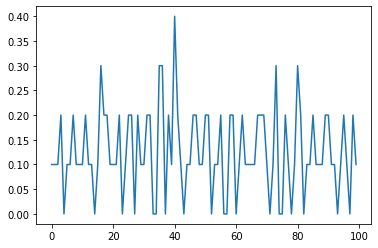

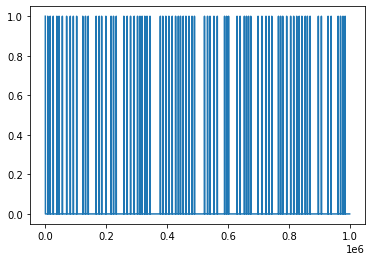

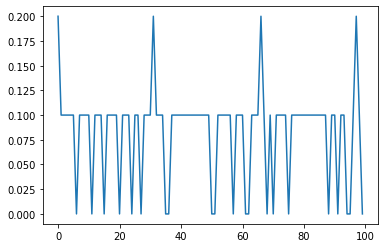

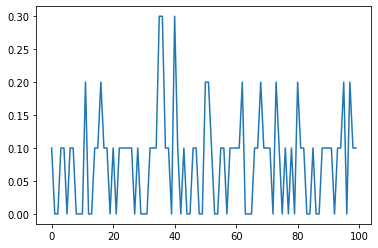

In [111]:
plt.figure()
plt.plot(in_freq)
plt.figure()
plt.plot(response)
plt.figure()
plt.plot(out_freq)
plt.figure()
plt.plot(dif_freq)

print(np.sum(count_in))
print(np.sum(count_out))